In [1]:
#Imports

import math
import numpy as np
from numpy import genfromtxt
from scipy import stats
from scipy.special import logit as lgTransform
from scipy.interpolate import UnivariateSpline
import pandas as pd
import statsmodels.api as sm 
import matplotlib.pylab as plt 
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
from statsmodels.formula.api import logit
%matplotlib inline

In [2]:
dfSynon = pd.read_csv('synonMetrics.csv')
dfMissense = pd.read_csv('missenseMetrics.csv')
dfLOF = pd.read_csv('lofMetrics.csv')

print(len(dfSynon))
print(len(dfMissense))
print(len(dfLOF))
print(dfSynon.head())
print(dfMissense.head())
print(dfLOF.head())

15809
15810
14064
           gene_id  expected_SYN  observed_SYN  observed/expected_SYN  \
0  ENSG00000187634     77.473684         106.0               1.368207   
1  ENSG00000188976    219.235725         263.0               1.199622   
2  ENSG00000187961    184.565205         255.0               1.381626   
3  ENSG00000187583    127.854090         132.0               1.032427   
4  ENSG00000188290     10.009585          18.0               1.798276   

  gene_SYN  gene_length  obs_syn  exp_syn  oe_syn    mu_syn   oe_lof  \
0   SAMD11        19696      270  158.980  1.6983  0.000009  0.89656   
1    NOC2L        15106      320  199.380  1.6049  0.000014  1.02910   
2   KLHL17         5129      360  201.090  1.7903  0.000016  0.90749   
3  PLEKHN1         9369      216  174.520  1.2377  0.000011  0.80467   
4     HES4         1211       53   41.769  1.2689  0.000002  1.69970   

   oe_syn_lower  oe_syn_upper  oe_lof_lower  oe_lof_upper  \
0         1.537         1.875         0.640      

In [3]:
dfNewFindingOld = pd.merge(dfSynon, dfMissense, on='gene_id', how='inner')
dfNewFinding = pd.merge(dfNewFindingOld, dfLOF, on='gene_id', how='inner')
print(dfNewFinding.head())
print(len(dfNewFinding))
print(dfNewFinding.columns)

#dfNewFinding.columns = ['gene_id', 'observed_SYN', 'expected_SYN', 'observed/expected_SYN', 'gene_SYN',
#        'LOEUF_SYN', 'posterior_distribution_mean_SYN', 'observed_MIS', 'expected_MIS',
#        'observed/expected_MIS', 'gene_MIS', 'LOEUF_MIS','posterior_distribution_mean_MIS', 
#         'observed_LOF', 'expected_LOF', 'observed/expected_LOF', 'gene_LOF', 'LOEUF_LOF', 'posterior_distribution_mean_LOF']
print(dfNewFinding.head())

           gene_id  expected_SYN  observed_SYN  observed/expected_SYN  \
0  ENSG00000187634     77.473684         106.0               1.368207   
1  ENSG00000188976    219.235725         263.0               1.199622   
2  ENSG00000187961    184.565205         255.0               1.381626   
3  ENSG00000187583    127.854090         132.0               1.032427   
4  ENSG00000188290     10.009585          18.0               1.798276   

  gene_SYN  gene_length_x  obs_syn  exp_syn  oe_syn    mu_syn  ...  obs_lof  \
0   SAMD11          19696      270  158.980  1.6983  0.000009  ...     22.0   
1    NOC2L          15106      320  199.380  1.6049  0.000014  ...     43.0   
2   KLHL17           5129      360  201.090  1.7903  0.000016  ...     26.0   
3  PLEKHN1           9369      216  174.520  1.2377  0.000011  ...     25.0   
4     HES4           1211       53   41.769  1.2689  0.000002  ...      6.0   

   exp_lof   oe_lof        mu_lof  oe_lof_lower  oe_lof_upper  \
0   24.538  0.89656  

In [4]:
dfNewFinding['z_syn_r'] = ((dfNewFinding.observed_SYN - dfNewFinding.expected_SYN) / np.sqrt(dfNewFinding.expected_SYN))
dfNewFinding['z_syn_g'] = ((dfNewFinding.obs_syn - dfNewFinding.exp_syn) / np.sqrt(dfNewFinding.exp_syn))

(array([  1.,   1.,   2.,   0.,   1.,   0.,   2.,   0.,   5.,  17.,  52.,
        119., 270., 496., 738., 970., 987., 871., 703., 510., 339., 243.,
        146.,  95.,  70.,  61.,  28.,  17.,  10.,  10.,   8.,   4.,   6.,
          3.,   3.,   1.,   2.,   1.,   1.,   1.,   0.,   1.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-5.57622171, -5.23826604, -4.90031038, -4.56235472, -4.22439905,
        -3.88644339, -3.54848772, -3.21053206, -2.8725764 , -2.53462073,
        -2.19666507, -1.8587094 , -1.52075374, -1.18279808, -0.84484241,
        -0.50688675, -0.16893108,  0.16902458,  0.50698024,  0.84493591,
         1.18289157,  1.52

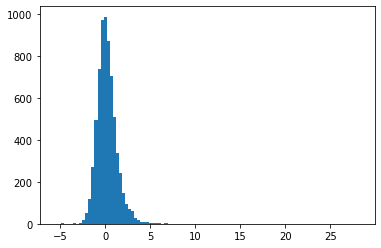

In [5]:
goodPred = dfNewFinding.loc[(np.abs(dfNewFinding.z_syn_r)<1) & (dfNewFinding.expected_SYN.to_numpy() > 50), :]
plt.hist(goodPred.z_syn_g, bins=100)

Text(0, 0.5, 'Gnomad O/E Ratio')

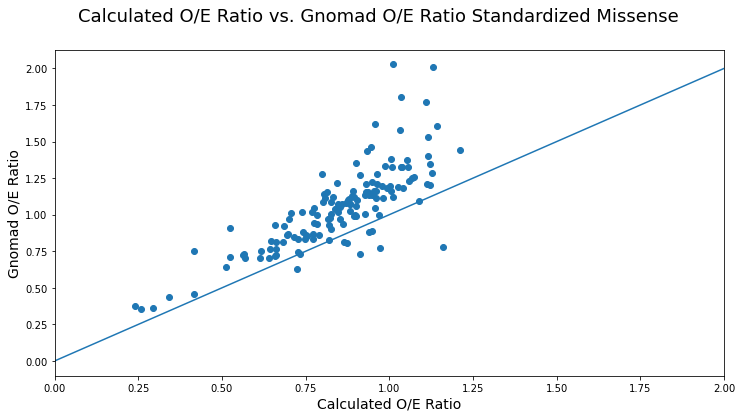

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

usGoodThemBad = goodPred.loc[np.abs(dfNewFinding.z_syn_g) > 3]
plt.scatter(usGoodThemBad['observed/expected_MIS'], usGoodThemBad.oe_mis)
#plt.scatter(usGoodThemBad['observed/expected_LoF'], usGoodThemBad.oe_lof)
plt.plot([0,2], [0,2])
plt.xlim([0,2])
# plt.hist(usGoodThemBad.LOEUF_MIS, bins=100, label="")
# plt.hist(usGoodThemBad.LOEUF_LoF, bins=100)

fig.suptitle('Calculated O/E Ratio vs. Gnomad O/E Ratio Standardized Missense', fontsize=18)
plt.xlabel('Calculated O/E Ratio', fontsize = 14)
plt.ylabel('Gnomad O/E Ratio', fontsize = 14)

Text(0, 0.5, 'Gnomad O/E Ratio')

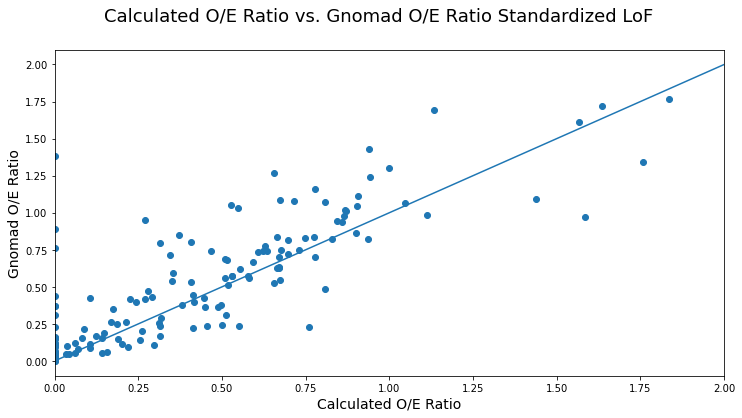

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

plt.scatter(usGoodThemBad['observed/expected_LoF'], usGoodThemBad.oe_lof)
plt.plot([0,2], [0,2])
plt.xlim([0,2])
# plt.hist(usGoodThemBad.LOEUF_MIS, bins=100, label="")
# plt.hist(usGoodThemBad.LOEUF_LoF, bins=100)

fig.suptitle('Calculated O/E Ratio vs. Gnomad O/E Ratio Standardized LoF', fontsize=18)
plt.xlabel('Calculated O/E Ratio', fontsize = 14)
plt.ylabel('Gnomad O/E Ratio', fontsize = 14)

                                 OLS Regression Results                                
Dep. Variable:                exp_syn   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                          7.360e+05
Date:                Wed, 04 Aug 2021   Prob (F-statistic):                        0.00
Time:                        17:22:03   Log-Likelihood:                         -65370.
No. Observations:               13950   AIC:                                  1.307e+05
Df Residuals:                   13949   BIC:                                  1.307e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

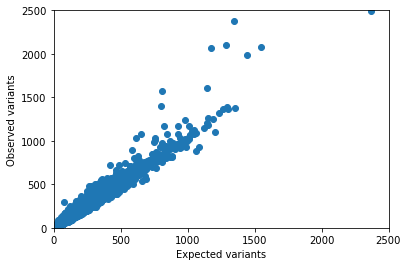

In [8]:
#plt.scatter(dfNewFinding['expected_SYN'], dfNewFinding['observed_SYN'])
plt.scatter(dfNewFinding['exp_syn'], dfNewFinding['obs_syn'])
plt.xlim([0,2500])
plt.ylim([0,2500])

plt.xlabel('Expected variants')
plt.ylabel('Observed variants')

oVeLinear = sm.OLS(dfNewFinding['exp_syn'], dfNewFinding['obs_syn'])
oVeSummary = oVeLinear.fit()
print(oVeSummary.summary())

                                 OLS Regression Results                                
Dep. Variable:                exp_mis   R-squared (uncentered):                   0.952
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                          2.764e+05
Date:                Wed, 04 Aug 2021   Prob (F-statistic):                        0.00
Time:                        17:22:03   Log-Likelihood:                         -84939.
No. Observations:               13950   AIC:                                  1.699e+05
Df Residuals:                   13949   BIC:                                  1.699e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

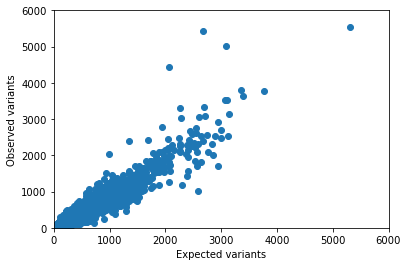

In [9]:
#plt.scatter(dfNewFinding['expected_MIS'], dfNewFinding['observed_MIS'])
plt.scatter(dfNewFinding['exp_mis'], dfNewFinding['obs_mis'])
plt.xlim([0,6000])
plt.ylim([0,6000])

plt.xlabel('Expected variants')
plt.ylabel('Observed variants')

oVeLinear = sm.OLS(dfNewFinding['exp_mis'], dfNewFinding['obs_mis'])
oVeSummary = oVeLinear.fit()
print(oVeSummary.summary())

                                 OLS Regression Results                                
Dep. Variable:                exp_lof   R-squared (uncentered):                   0.657
Model:                            OLS   Adj. R-squared (uncentered):              0.657
Method:                 Least Squares   F-statistic:                          2.677e+04
Date:                Wed, 04 Aug 2021   Prob (F-statistic):                        0.00
Time:                        17:22:03   Log-Likelihood:                         -64046.
No. Observations:               13949   AIC:                                  1.281e+05
Df Residuals:                   13948   BIC:                                  1.281e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

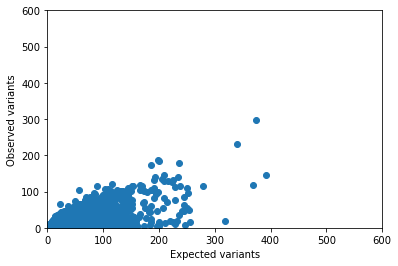

In [10]:
#Remove Gene ENSG00000169900 because it contains NaN for exp_lof and obs_lof from Gnomad Data
dfNewFinding = dfNewFinding.dropna(subset=['exp_lof'])

#plt.scatter(dfNewFinding['expected_LoF'], dfNewFinding['observed_LoF'])
plt.scatter(dfNewFinding['exp_lof'], dfNewFinding['obs_lof'])
plt.xlim([0,600])
plt.ylim([0,600])

plt.xlabel('Expected variants')
plt.ylabel('Observed variants')

oVeLinear = sm.OLS(dfNewFinding['exp_lof'], dfNewFinding['obs_lof'])
oVeSummary = oVeLinear.fit()
print(oVeSummary.summary())